In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#Datetime

In [ ]:
df = pd.read_csv('/content/CleanedProductData.csv')

In [ ]:
from datetime import datetime

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df['week'] =df['Date'].dt.week
df['month'] =df['Date'].dt.month
df['year'] =df['Date'].dt.year

In [ ]:
df.groupby('month')['Weekly_Sales'].mean()

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [ ]:
df.groupby('year')['Weekly_Sales'].mean()

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

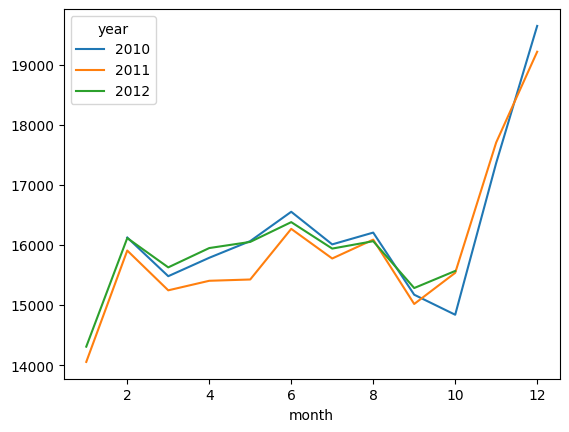

In [ ]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

In [ ]:
df.head()

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Super_Bowl,Labor_Day,Thanksgiving,New Year,week,month,year
0,0,1,1,2010-02-05,24924.50,False,False,False,False,False,5,2,2010
1,1,1,2,2010-02-05,50605.27,False,False,False,False,False,5,2,2010
2,2,1,3,2010-02-05,13740.12,False,False,False,False,False,5,2,2010
3,3,1,4,2010-02-05,39954.04,False,False,False,False,False,5,2,2010
4,4,1,5,2010-02-05,32229.38,False,False,False,False,False,5,2,2010


In [ ]:
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
df.set_index('Date', inplace=True)

In [ ]:
df_week = df.resample('W').mean()

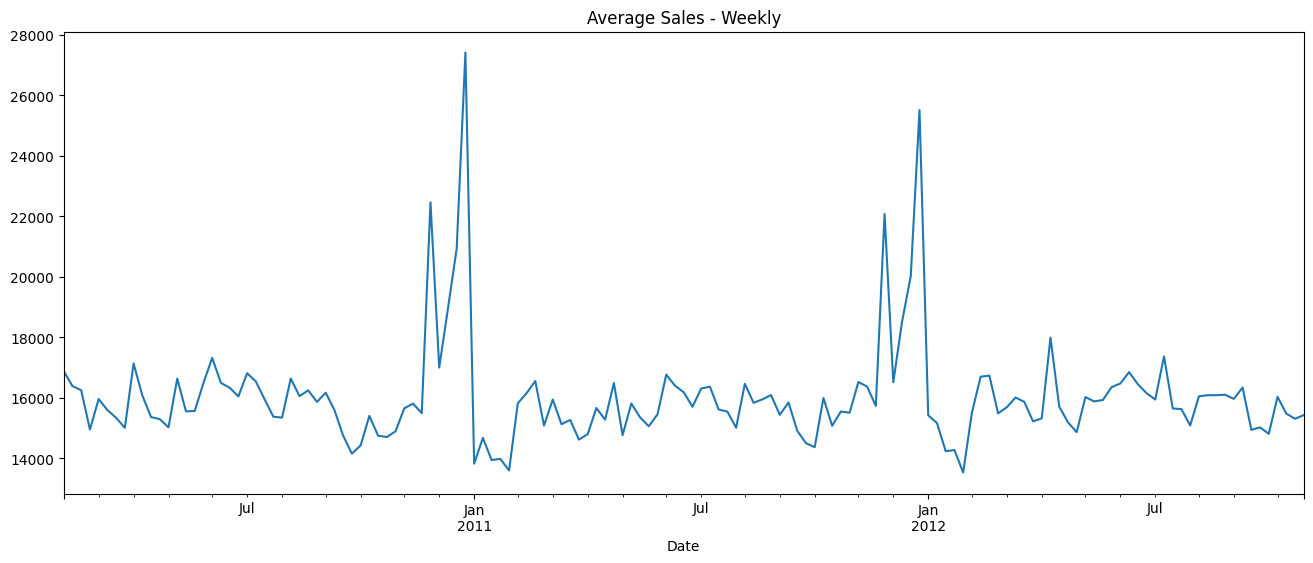

In [ ]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

####CHECK STATIONARITY

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737572,
 2.4290492082042356e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

weakly stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
kpss_test_result = kpss(df_week['Weekly_Sales'])
print("KPSS Test Statistic:", kpss_test_result[0])
print("p-value:", kpss_test_result[1])
print("Critical Values:", kpss_test_result[3])

KPSS Test Statistic: 0.03260888081113806
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


non stationary

##we assume the data is stationary

In [ ]:
train_data = df_week[:int(0.8*(len(df_week)))]
test_data = df_week[int(0.8*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (114, 12)
Test: (29, 12)


In [ ]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]]

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

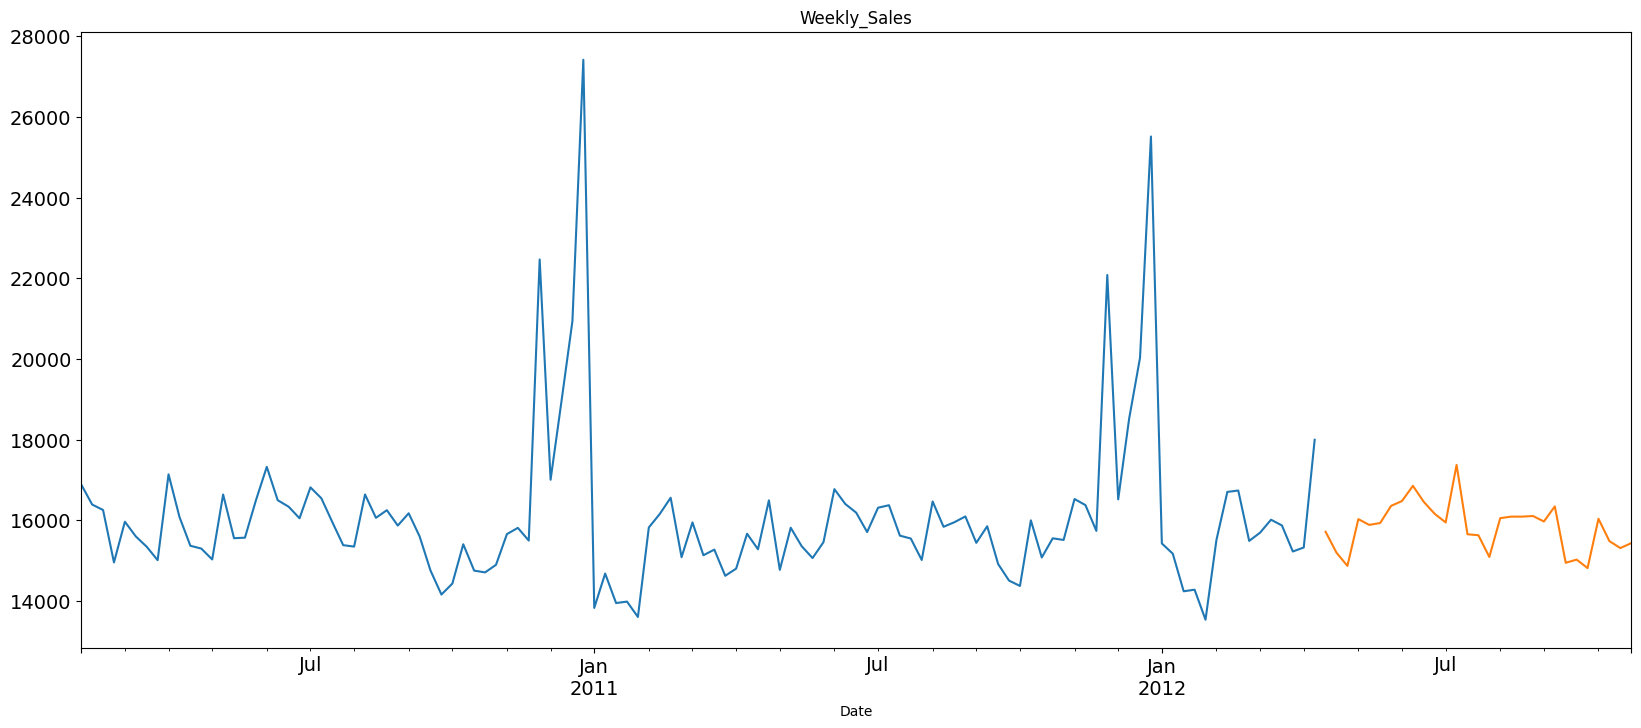

In [ ]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

#ARIMA

In [ ]:
import pmdarima as pm

ModuleNotFoundError: ignored

In [ ]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values

In [ ]:
train_data_diff = df_week_diff [:int(0.8*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.8*(len(df_week_diff ))):]

In [ ]:
model_auto_arima = pm.auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

In [ ]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_values = test_data_diff
predicted_values = y_pred['Prediction'].values

mae = mean_absolute_error(actual_values, predicted_values)

mse = mean_squared_error(actual_values, predicted_values)

rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

# W/O Stationarity

In [ ]:
model_auto_arima = pm.auto_arima(train_data['Weekly_Sales'], trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data['Weekly_Sales'])

In [ ]:
y_pred = model_auto_arima.predict(n_periods=len(test_data['Weekly_Sales']))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data['Weekly_Sales'], label='Train')
plt.plot(test_data['Weekly_Sales'], label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

#SARIMA and model accuracy

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

model_auto_sarima = pm.auto_arima(
    train_data_diff,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    seasonal=True,
    m=7,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

print("Auto-SARIMA Model Order:", model_auto_sarima.order)
print("Auto-SARIMA Seasonal Order:", model_auto_sarima.seasonal_order)

model_sarima = SARIMAX(train_data_diff,
                       order=model_auto_sarima.order,
                       seasonal_order=model_auto_sarima.seasonal_order)
results = model_sarima.fit(disp=True)

y_pred_sarima = results.predict(start=len(train_data_diff),
                                end=len(train_data_diff) + len(test_data_diff) - 1,
                                dynamic=False)

y_pred_sarima = y_pred_sarima.cumsum()

plt.figure(figsize=(20, 6))
plt.title('Prediction of Weekly Sales Using Auto-SARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(test_data.index, y_pred_sarima, label='Prediction of SARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [ ]:
mae_sarima = mean_absolute_error(test_data_diff, y_pred_sarima)
mse_sarima = mean_squared_error(test_data_diff, y_pred_sarima)
rmse_sarima = np.sqrt(mse_sarima)

print("SARIMA Mean Absolute Error (MAE):", mae_sarima)
print("SARIMA Mean Squared Error (MSE):", mse_sarima)
print("SARIMA Root Mean Squared Error (RMSE):", rmse_sarima)

#both are not suited

#exponential smoothing

I checked suitable Holt-Winters models according tp my data. Exponential Smooting are used when data has trend, and it flattens the trend. The damped trend method adds a damping parameter so, the trend converges to a constant value in the future.


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit()
y_pred = model_holt_winters.forecast(len(test_data_diff))

plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [ ]:
mae = mean_absolute_error(test_data_diff, y_pred)
mse = mean_squared_error(test_data_diff, y_pred)

print("ES Mean Absolute Error (MAE):", mae)
print("ES Mean Squared Error (MSE):", mse)

In [ ]:
import pickle

with open('model_ES.pkl', 'wb') as file:
    pickle.dump(model_holt_winters, file)